# Facebook Check ins Project

## All work taken from Sandro, 

### MAS Score = 

## Data Exploration

In [4]:
from pandas import DataFrame, Series
import pandas as pd
import numpy as np
import matplotlib
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier

import statsmodels.api as sm
from sklearn.cross_validation import train_test_split

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr

# make plots appear when you call them
%matplotlib inline 


In [5]:
traindf = pd.read_csv("train.csv")
print(traindf.head())
print(traindf.describe())


   row_id       x       y  accuracy    time    place_id
0       0  0.7941  9.0809        54  470702  8523065625
1       1  5.9567  4.7968        13  186555  1757726713
2       2  8.3078  7.0407        74  322648  1137537235
3       3  7.3665  2.5165        65  704587  6567393236
4       4  4.0961  1.1307        31  472130  7440663949
             row_id             x             y      accuracy          time  \
count  2.911802e+07  2.911802e+07  2.911802e+07  2.911802e+07  2.911802e+07   
mean   1.455901e+07  4.999770e+00  5.001814e+00  8.284912e+01  4.170104e+05   
std    8.405649e+06  2.857601e+00  2.887505e+00  1.147518e+02  2.311761e+05   
min    0.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00  1.000000e+00   
25%    7.279505e+06  2.534700e+00  2.496700e+00  2.700000e+01  2.030570e+05   
50%    1.455901e+07  5.009100e+00  4.988300e+00  6.200000e+01  4.339220e+05   
75%    2.183852e+07  7.461400e+00  7.510300e+00  7.500000e+01  6.204910e+05   
max    2.911802e+07  1.000000e+0

In [6]:
print("Unique places:"+ str(traindf.place_id.unique().size))
print("Avg samples per places:" +str(len(traindf)/float(traindf.place_id.unique().size)))


Unique places:108390
Avg samples per places:268.6412122889565


In [7]:
#do visualizations with a random sample of the data 
df_train_sample = traindf.sample(n=1000000)

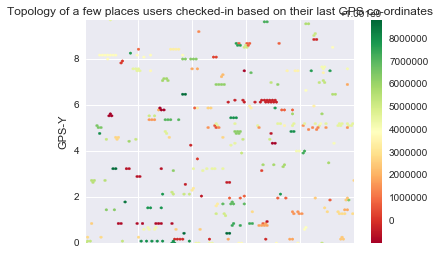

In [8]:
#modified from Kernal by yrevar
df_train_graph_sample = df_train_sample.sort_values(by="place_id")[:1000].copy()
ax = df_train_graph_sample.plot(kind='hexbin', x='x', y='y', C='place_id', colormap='RdYlGn')
ax.set_xlabel("GPS-X")
ax.set_ylabel("GPS-Y")
ax.set_title("Topology of a few places users checked-in based on their last GPS co-ordinates")


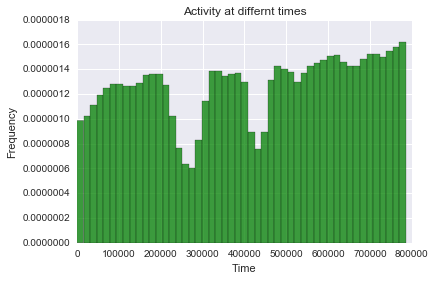

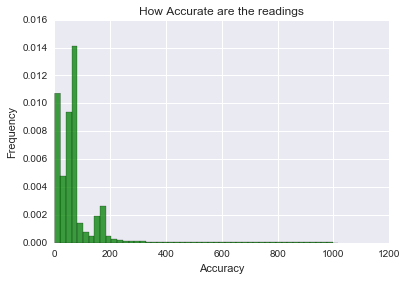

In [9]:
n, bins, patches = plt.hist(df_train_sample['time'], 50, normed=1, facecolor='green', alpha=0.75)
plt.title('Activity at differnt times')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

n, bins, patches = plt.hist(df_train_sample['accuracy'], 50, normed=1, facecolor='green', alpha=0.75)
plt.title('How Accurate are the readings')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.show()



In [10]:
print(df_train_sample.query('place_id == 7027539516').x.describe())
print(df_train_sample.query('place_id == 7027539516').y.describe())


count    29.000000
mean      6.428510
std       0.039748
min       6.347500
25%       6.400300
50%       6.434900
75%       6.454000
max       6.517800
Name: x, dtype: float64
count    29.000000
mean      3.101314
std       0.009342
min       3.085200
25%       3.094400
50%       3.101500
75%       3.107000
max       3.123000
Name: y, dtype: float64


For check-ins to the this location, it seems like X has a larger spread than Y. This trend seems to be true for most locations:

In [11]:
x_var, y_var, n = 0, 0, 10
for x in range(n):
    place_id = df_train_sample.place_id.unique()[x]
    df_place = df_train_sample[df_train_sample["place_id"]==place_id]
    x_var += df_place["x"].var()
    y_var += df_place["y"].var()
print("variance in x(%) " + str(x_var*100/n))
print("variance in y(%) " + str(y_var*100/n))

variance in x(%) nan
variance in y(%) nan


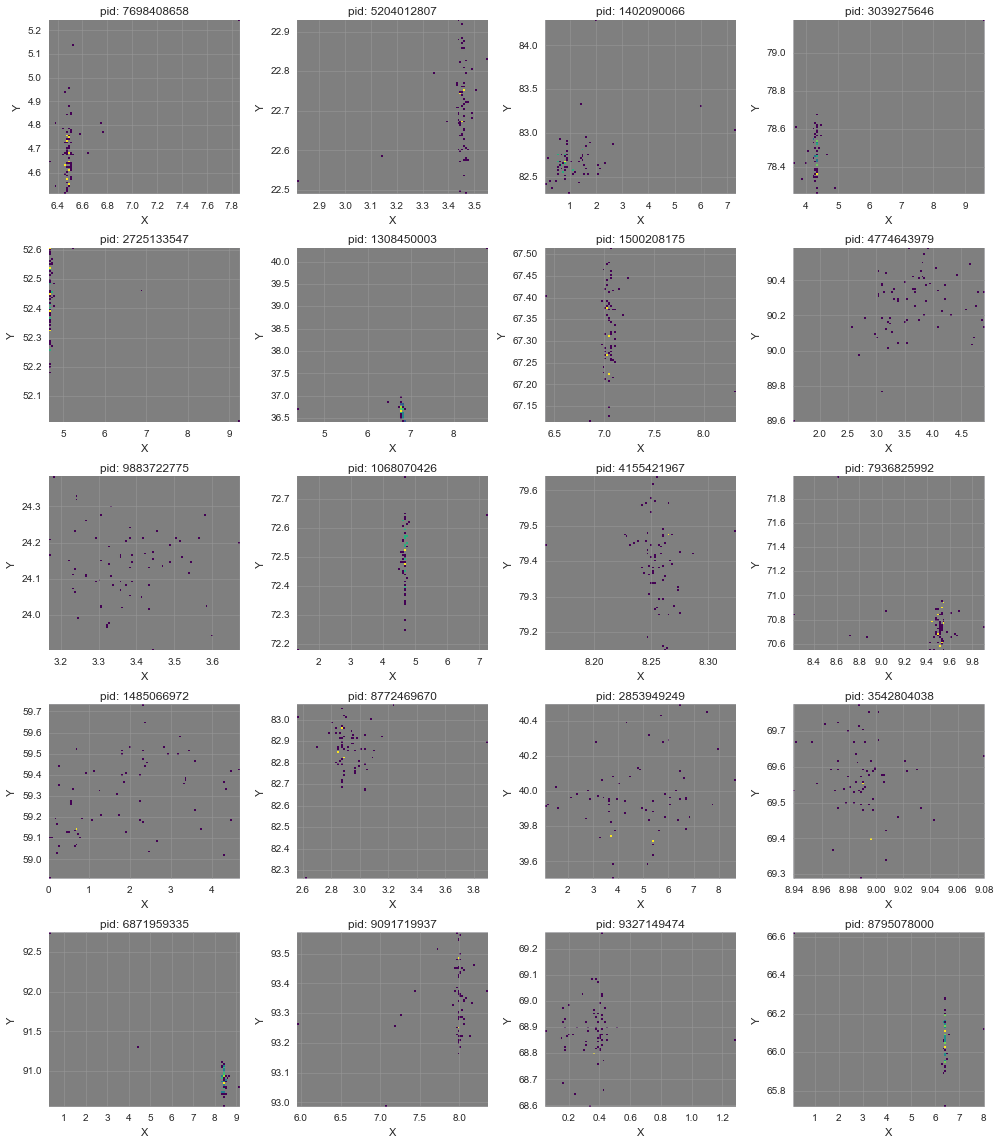

In [12]:
#Modified from Kernel by TusharGupta 
df_placecounts = df_train_sample["place_id"].value_counts()
df_topplaces = df_placecounts.iloc[0:20]
l_topplaces = list(df_topplaces.index)

plt.figure(10, figsize=(14,16))
cmapm = plt.cm.viridis
cmapm.set_bad("0.5",1.)

for i in range(len(l_topplaces)):
    place = l_topplaces[i]
    df_place = df_train_sample[df_train_sample["place_id"]==place]
    counts, binsX, binsY = np.histogram2d(df_place["x"], df_place["y"] *10 , bins=100)
    extent = [binsX.min(),binsX.max(),binsY.min(),binsY.max()]

    plt.subplot(5,4,i+1)
    plt.imshow(np.log10(counts.T),
               interpolation='none',
               origin='lower',
               extent=extent,
               aspect="auto",
               cmap=cmapm)
    plt.grid(True, c='0.6', lw=0.5)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title("pid: " + str(place))

plt.tight_layout()
plt.show()


Again, for the top 20 cases, we see how spread out it is in the X direction compared to the y direction (notice how small the scale is in the y direction).

## Feature Engineering

In [13]:
testdf = pd.read_csv("test.csv")
print(testdf.head())
print(testdf.describe())

   row_id       x       y  accuracy    time
0       0  0.1675  1.3608       107  930883
1       1  7.3909  2.5301        35  893017
2       2  8.0978  2.3473        62  976933
3       3  0.9990  1.0591        62  907285
4       4  0.6670  9.7254        40  914399
             row_id             x             y      accuracy          time
count  8.607230e+06  8.607230e+06  8.607230e+06  8.607230e+06  8.607230e+06
mean   4.303614e+06  4.991417e+00  5.006705e+00  9.265208e+01  8.904637e+05
std    2.484693e+06  2.866409e+00  2.886888e+00  1.242906e+02  6.446783e+04
min    0.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00  7.862420e+05
25%    2.151807e+06  2.517000e+00  2.502400e+00  4.200000e+01  8.332200e+05
50%    4.303614e+06  4.988000e+00  5.000900e+00  6.400000e+01  8.874620e+05
75%    6.455422e+06  7.463600e+00  7.505300e+00  7.900000e+01  9.454910e+05
max    8.607229e+06  1.000000e+01  1.000000e+01  1.026000e+03  1.006589e+06


In [14]:
testdf = testdf.drop(["accuracy"], axis=1)
traindf = traindf.drop(["accuracy"], axis=1)

In [15]:
def prepare_data(df):
    #create the grid
    size_x = 10./20
    size_y = 10./40
    eps = 0.00001
    xs = np.where(df.x.values < eps, 0, df.x.values - eps)
    ys = np.where(df.y.values < eps, 0, df.y.values - eps)
    pos_x = (xs / size_x).astype(np.int)
    pos_y = (ys / size_y).astype(np.int)
    df['grid_cell'] = pos_y * n_cell_x + pos_x
    
    #feature engineering
    #Feature engineering
    fw = [500, 1000, 4, 3, 1./22., 2, 10] #feature weights courtesy of Sandro's black magic
    df.x = df.x.values * fw[0]
    df.y = df.y.values * fw[1]
    initial_date = np.datetime64('2014-01-01T01:01', dtype='datetime64[m]') 
    d_times = pd.DatetimeIndex(initial_date + np.timedelta64(int(mn), 'm') 
                               for mn in df.time.values)    
    df['hour'] = d_times.hour * fw[2]
    df['weekday'] = d_times.weekday * fw[3]
    df['day'] = (d_times.dayofyear * fw[4]).astype(int)
    df['month'] = d_times.month * fw[5]
    df['year'] = (d_times.year - 2013) * fw[6]

    df = df.drop(['time'], axis=1) 
    return df

In [16]:
df_train = prepare_data(traindf)
df_test = prepare_data(testdf)

NameError: name 'n_cell_x' is not defined

## Model Building

In [ ]:
def process_one_cell(df_train, df_test, grid_id, th):
    """   
    Classification inside one grid cell.
    """   
    #Working on df_train
    df_cell_train = df_train.loc[df_train.grid_cell == grid_id]
    place_counts = df_cell_train.place_id.value_counts()
    mask = (place_counts[df_cell_train.place_id.values] >= th).values
    df_cell_train = df_cell_train.loc[mask]

    #Working on df_test
    df_cell_test = df_test.loc[df_test.grid_cell == grid_id]
    row_ids = df_cell_test.index
    
    #Preparing data
    le = LabelEncoder()
    y = le.fit_transform(df_cell_train.place_id.values)
    X = df_cell_train.drop(['place_id', 'grid_cell'], axis=1).values.astype(int)
    X_test = df_cell_test.drop(['grid_cell'], axis = 1).values.astype(int)
    
    #Applying the classifier
    clf = KNeighborsClassifier(n_neighbors=25, weights='distance', 
                               metric='manhattan')
    clf.fit(X, y)
    y_pred = clf.predict_proba(X_test)
    pred_labels = le.inverse_transform(np.argsort(y_pred, axis=1)[:,::-1][:,:3])    
    return pred_labels, row_ids

In [ ]:
def process_grid(df_train, df_test, th, n_cells):
    """
    Iterates over all grid cells, aggregates the results and makes the
    submission.
    """ 
    preds = np.zeros((df_test.shape[0], 3), dtype=int)
    
    for g_id in range(n_cells):
        
        #Applying classifier to one grid cell
        pred_labels, row_ids = process_one_cell(df_train, df_test, g_id, th)

        #Updating predictions
        preds[row_ids] = pred_labels

    #Auxiliary dataframe with the 3 best predictions for each sample
    df_aux = pd.DataFrame(preds, dtype=str, columns=['l1', 'l2', 'l3'])  
    
    #Concatenating the 3 predictions for each sample
    ds_sub = df_aux.l1.str.cat([df_aux.l2, df_aux.l3], sep=' ')
    
    #Writting to csv
    ds_sub.name = 'place_id'
    ds_sub.to_csv('sub_knn.csv', index=True, header=True, index_label='row_id')  

In [ ]:
process_grid(df_train, df_test, 5, 800)

In [ ]:
"""
Cross Validation

This code was adapted from lecture code as well as Sandro's grid_knn code,
found at https://www.kaggle.com/svpons/facebook-v-predicting-check-ins/grid-knn/code.
"""

from sklearn.cross_validation import cross_val_score, train_test_split

def cv_check_cell(df_train, grid_id, th):
    """Calculates the mean and standard deviation of 5 folds of a single cell."""
    
    #Working on df_train
    df_cell_train = df_train.loc[df_train.grid_cell == grid_id]
    place_counts = df_cell_train.place_id.value_counts()
    mask = (place_counts[df_cell_train.place_id.values] >= th).values
    df_cell_train = df_cell_train.loc[mask]
    
    #Preparing data
    le = LabelEncoder()
    y = le.fit_transform(df_cell_train.place_id.values)
    X = df_cell_train.drop(['place_id', 'grid_cell'], axis=1).values.astype(int)
    
    #Applying the classifier
    clf = KNeighborsClassifier(n_neighbors=25, weights='distance', 
                               metric='manhattan')
    
    #Creating Train and Test samples
    X_train, X_test,y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    #Calculating CLF score, mean, and standard deviation
    clf_score = cross_val_score(clf, X_train, y_train,cv =5)
    mean = np.mean(clf_score)
    std = np.std(clf_score)
    
    return mean, std
    
def cv_check_grid(df_train, th, n_cells):
    """Calculates the means and standard deviations of n_cells and prints out the first five."""
    
    stats_dict = {}
    for g_id in range(n_cells):
        
        #Calculating mean and standard deviation of each cell
        mean, std = cv_check_cell(df_train, df_test, g_id, th)

        #Inserting mean and standard deviation into dictionary
        stats_dict[g_id] = (mean, std)
    
    #Printing out the first five means/stds generated
    for i in range(5):
        print(str(i) + " => " + str(stats_dict[i]))
        

def cross_val_check():
    cv_check_grid(df_train, 5, 800)